In [1]:
import os
import numpy as np

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from keras.datasets import mnist

from PIL import Image

Using TensorFlow backend.


In [2]:
recriate = True

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
def view_images(imagens):
    plt.gray()
    fig=plt.figure(figsize=(16, 20))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = imagens[i - 1]
        ax = fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    

In [4]:
def model():
    input_img = Input(shape=(128, 128, 1))
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder


In [16]:
CAMINHO = '/floyd/data/images'
SIZE = 128, 128
noise_factor = 0

def image_generator(filenames):
    for filename in filenames:
        image = Image.open(os.path.join(CAMINHO, filename))
        image = image.resize(SIZE, Image.ANTIALIAS)
        image_array = np.asarray(image).astype('float32')
        image_array = image_array[:, :, 0] / 255
        # images.append(image_array)
        image_noisy = image_array + noise_factor * \
            np.random.normal(loc=0.5, scale=0.33, size=image_array.shape)
        image_noisy = np.clip(image_noisy, 0., 1.)
        # images_noisy.append(image_noisy)
        yield image_array, image_noisy

def get_chunks(imagegenerator, chunk_size):
    images = []
    images_noisy = []
    for index in range(chunk_size):
        (image, noisy) = next(imageg)
        images.append(image)
        images_noisy.append(noisy)
        
    return images, images_noisy

dir_path = CAMINHO
extension = '.jpg'
position = len(extension)
filenames = [filename 
             for filename in os.listdir(dir_path) 
             if filename[-position:] == extension]
# filenames = filenames[:100]
imageg = image_generator(filenames)

In [6]:
CHUNK_SIZE = 16

images, images_noisy = get_chunks(imageg, CHUNK_SIZE)
print(len(images))
print(images[0].shape)
print(images_noisy[0].shape)                               

16
(128, 128)
(128, 128)


<Figure size 432x288 with 0 Axes>

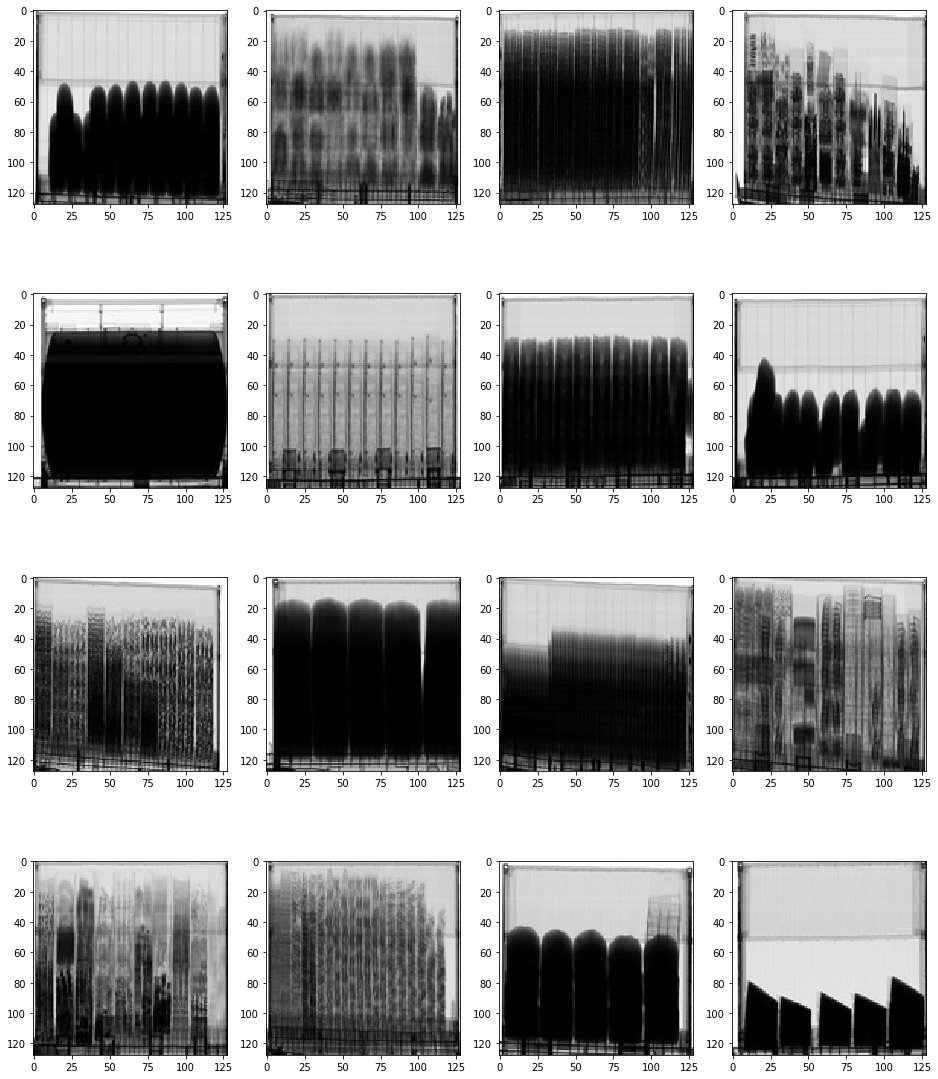

In [7]:
view_images(images)

<Figure size 432x288 with 0 Axes>

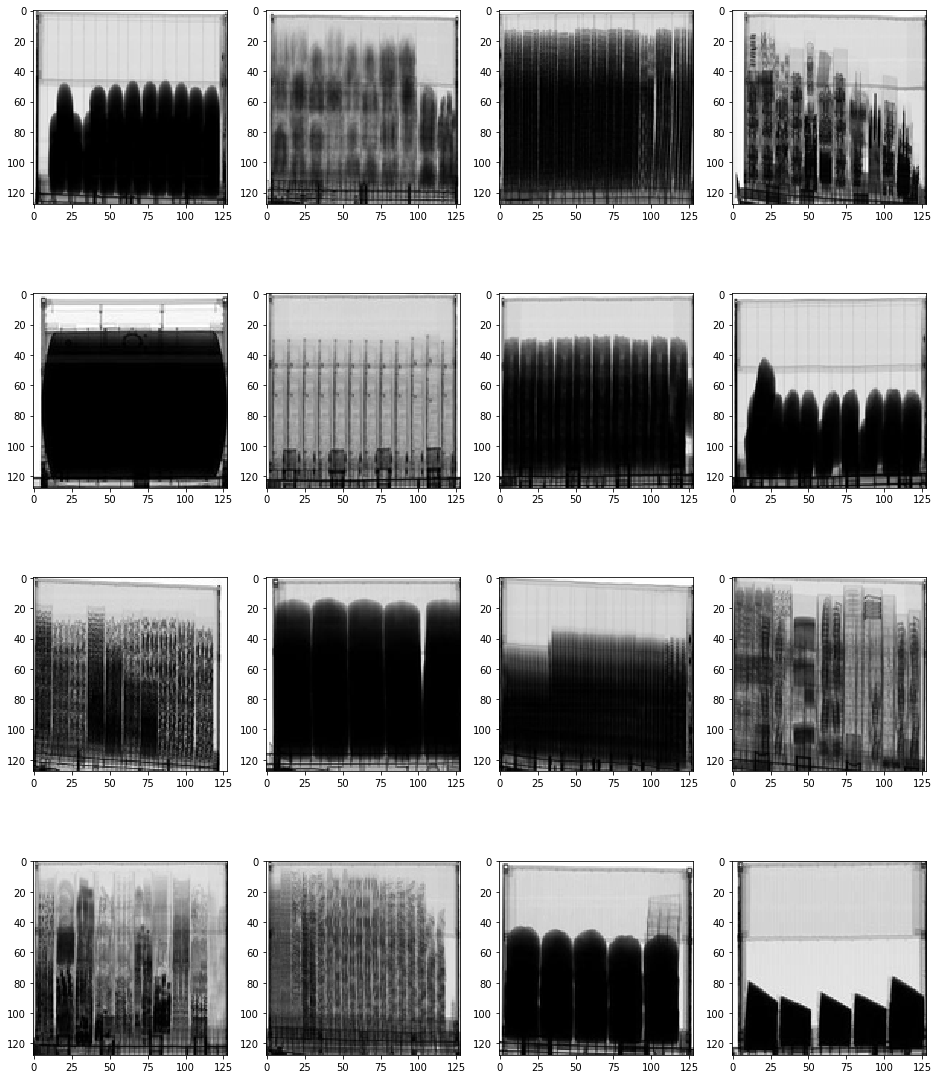

In [8]:
view_images(images_noisy)

In [17]:
y_train, x_train = get_chunks(imageg, 6000)

X_train = np.asarray(x_train)
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)
Y_train = np.asarray(y_train)
Y_train = np.expand_dims(Y_train, axis=3)
print(Y_train.shape)

(6000, 128, 128, 1)
(6000, 128, 128, 1)


In [18]:
y_test, x_test = get_chunks(imageg, 1000)

X_test = np.asarray(x_test)
X_test = np.expand_dims(X_test, axis=3)
print(X_test.shape)
Y_test = np.asarray(y_test)
Y_test = np.expand_dims(Y_test, axis=3)
print(Y_test.shape)

(1000, 128, 128, 1)
(1000, 128, 128, 1)


In [19]:
if recriate:
    autoencoder = model()
else:
    r = 'USANDO'
    autoencoder = load_model(f'autoencoder{r}.h5')

In [ ]:
autoencoder.summary()

In [20]:
#for i in range(1, 101, 10):
autoencoder.fit(X_train, Y_train,
                epochs=100,
                # initial_epoch=i                
                shuffle=True,
                batch_size=256,
                validation_data=(X_test, Y_test))
autoencoder.save(f'autoencoderGPU.h5')

Train on 6000 samples, validate on 1000 samples
Epoch 1/100
6000/6000 [==============================] - 8s 1ms/step - loss: 0.6283 - val_loss: 0.5210
Epoch 2/100
6000/6000 [==============================] - 5s 789us/step - loss: 0.4894 - val_loss: 0.4614
Epoch 3/100
6000/6000 [==============================] - 5s 789us/step - loss: 0.4569 - val_loss: 0.4546
Epoch 4/100
6000/6000 [==============================] - 5s 792us/step - loss: 0.4497 - val_loss: 0.4548
Epoch 5/100
6000/6000 [==============================] - 5s 790us/step - loss: 0.4455 - val_loss: 0.4429
Epoch 6/100
6000/6000 [==============================] - 5s 790us/step - loss: 0.4429 - val_loss: 0.4396
Epoch 7/100
6000/6000 [==============================] - 5s 791us/step - loss: 0.4399 - val_loss: 0.4375
Epoch 8/100
6000/6000 [==============================] - 5s 791us/step - loss: 0.4377 - val_loss: 0.4361
Epoch 9/100
6000/6000 [==============================] - 5s 791us/step - loss: 0.4378 - val_loss: 0.4326
Epoch 10/

In [89]:
r = 'GPU'
autoencoder = load_model(f'autoencoder{r}.h5')

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_denoised_images(noisy, image, original):
    plt.gray()
    fig=plt.figure(figsize=(16, 10))
    i = 0
    for r in range(4):
        i += 1
        ax = fig.add_subplot(4, 3, i)
        plt.imshow(noisy[r-1])
        i += 1
        ax = fig.add_subplot(4, 3, i)
        plt.imshow(image[r-1])
        i += 1
        ax = fig.add_subplot(4, 3, i)
        plt.imshow(original[r-1])
    plt.show()



<Figure size 432x288 with 0 Axes>

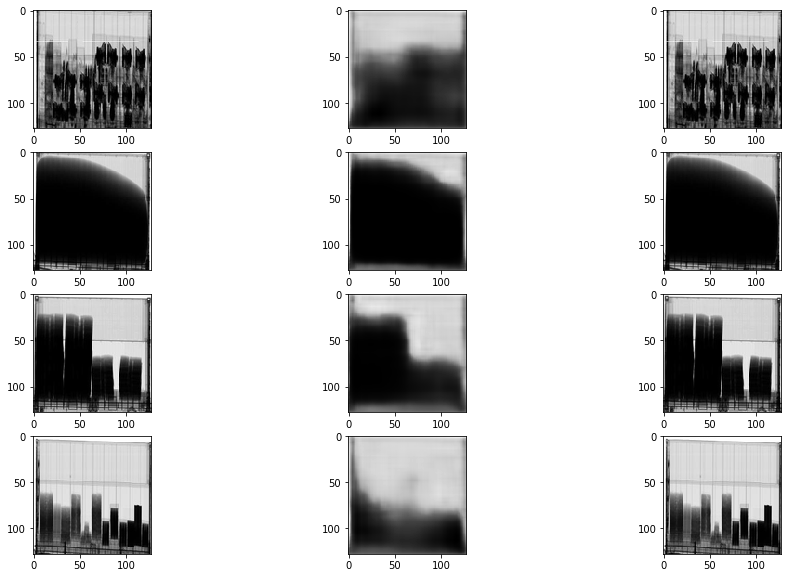

<Figure size 432x288 with 0 Axes>

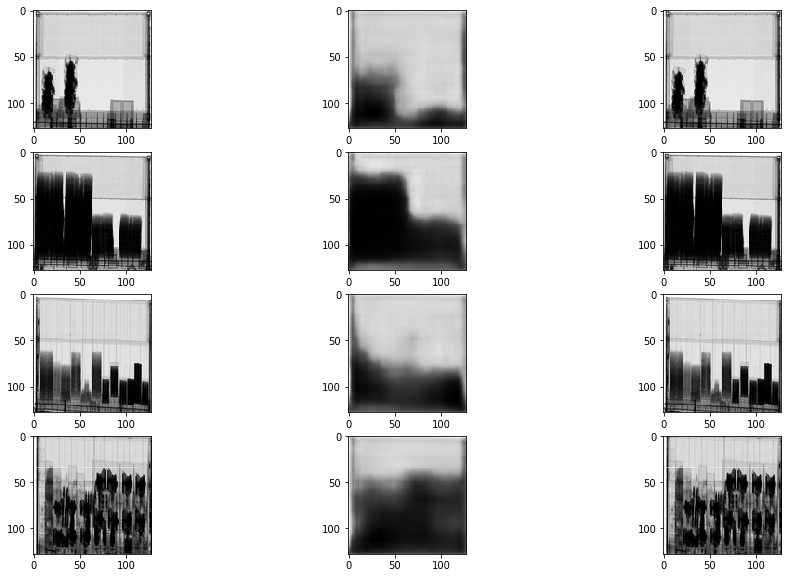

<Figure size 432x288 with 0 Axes>

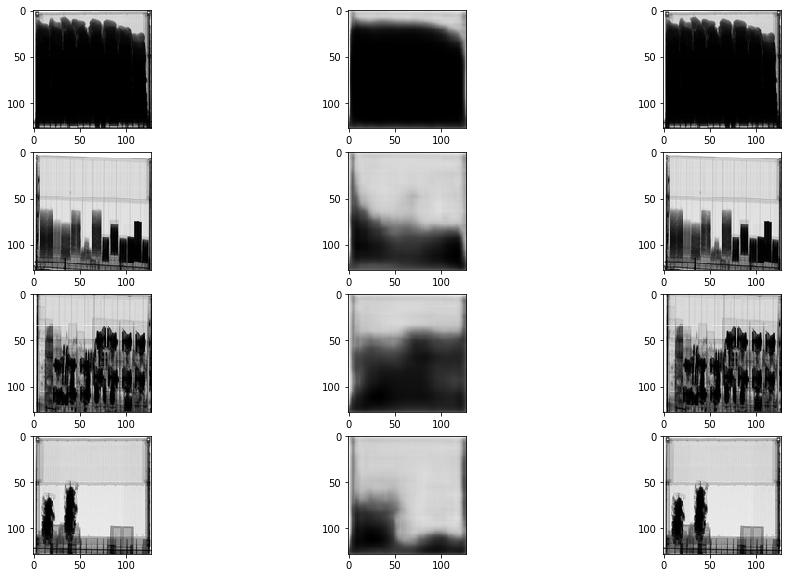

<Figure size 432x288 with 0 Axes>

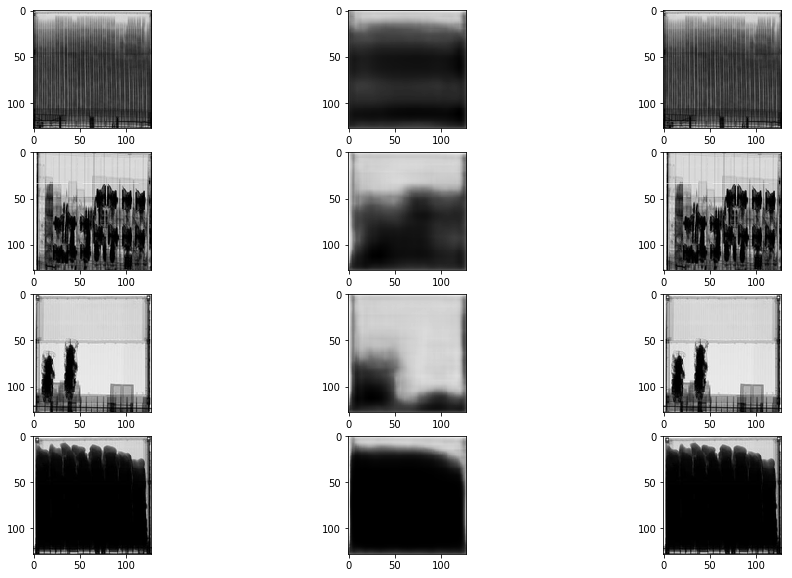

In [22]:
for i in range(4):    
    test_img = np.asarray([X_test[i:i+4]])
    test_img = test_img.reshape(4, 128, 128, 1)
    orig_img = np.asarray([Y_test[i:i+4]])
    denoised_images = autoencoder.predict(test_img)
    noisy = test_img.reshape(4, 128, 128)
    image = denoised_images.reshape(4, 128, 128)
    original = orig_img.reshape(4, 128, 128)
    plot_denoised_images(noisy, image, original)

In [24]:
# Get encoder layer from trained model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

learned_codes = encoder.predict(np.asarray([X_train]).reshape(6000, 128, 128, 1))


In [96]:
print(learned_codes.shape)
print(learned_codes[:1])

(5000, 4, 4, 8)
[[[[401969.47       0.    584050.75  119400.18  240959.97  468644.16
    674392.75       0.   ]
   [414385.         0.    601875.56  124588.69  256346.77  486959.5
    696859.44       0.   ]
   [435760.47       0.    630285.1   125488.89  252508.78  492480.3
    718989.6        0.   ]
   [440078.38       0.    634613.9   122709.46  221672.8   484985.3
    717146.8        0.   ]]

  [[363137.97       0.    532355.75  113529.64  245729.6   443480.47
    626534.8        0.   ]
   [369172.25       0.    543523.25  118001.87  264096.12  460267.7
    645777.06       0.   ]
   [411508.56       0.    601110.8   122884.92  268033.8   482895.06
    700324.4        0.   ]
   [431949.3        0.    625719.44  121710.914 223596.89  481569.28
    713494.3        0.   ]]

  [[299945.06       0.    432732.34   82988.69  149020.78  328851.53
    488353.62       0.   ]
   [297895.38       0.    429185.22   82401.02  147479.5   326033.5
    483688.94       0.   ]
   [361094.47       0.   

In [97]:
from sklearn.metrics.pairwise import euclidean_distances

def flat_array(array):
    return array.reshape(array.shape[0], array.shape[1] * array.shape[2] * array.shape[3])

In [102]:
index_0 = encoder.predict(np.asarray([X_train[666]]))
index_0_flat = index_0.reshape(1, index_0.shape[1] * index_0.shape[2] * index_0.shape[3])
learned_codes_flat = flat_array(learned_codes)
indexes = euclidean_distances(index_0_flat, learned_codes_flat)

In [103]:
indexes = indexes.reshape(5000)

In [104]:
seq = np.argsort(indexes)

(128, 128)


<Figure size 432x288 with 0 Axes>

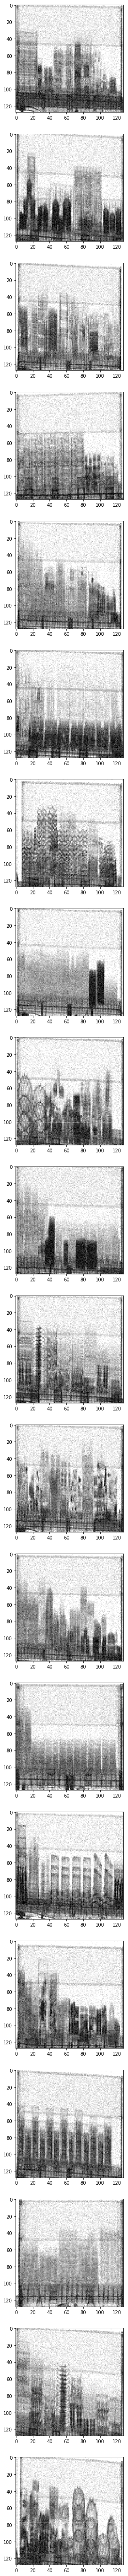

In [105]:
test_img = np.asarray([X_train])
test_img = test_img.reshape(5000, 128, 128)
print(test_img[0].shape)
plt.gray()
fig=plt.figure(figsize=(10, 100))
for r in range(20):
    ax = fig.add_subplot(20, 1, r + 1)
    plt.imshow(test_img[seq[r]])
plt.show()
